In [1]:
# configuring path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/time_series
!pwd

/content/drive/MyDrive/Colab Notebooks/time_series
/content/drive/MyDrive/Colab Notebooks/time_series


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Importing the Keras libraries and packages
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint,EarlyStopping

In [5]:
# load data
df = pd.read_csv('for_time_series_forceasting_pedestrian_count.tsv', sep='\t')
# dataframe hard copy for normalization
df_norm = df.copy()

original data


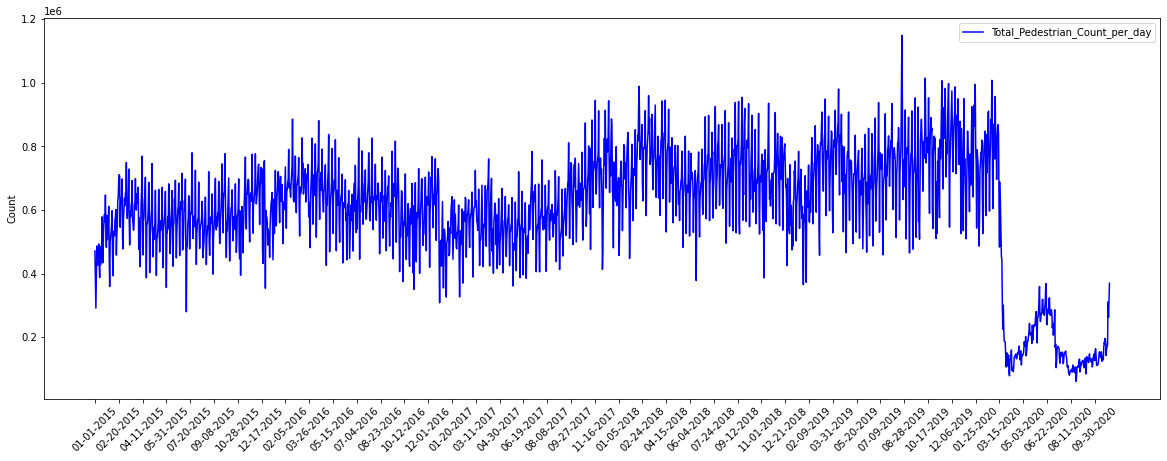

In [6]:
# show pedestrian count each day
print('original data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df)), df['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df),50),df['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()


Normalized data


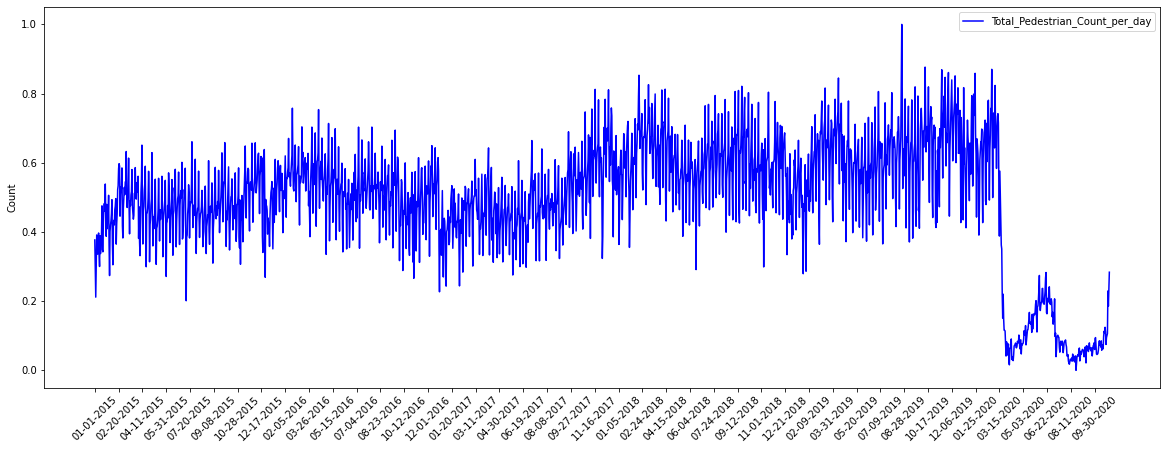

In [7]:
# Data Normalization
scaler = MinMaxScaler()
df_norm.iloc[:,1:] = scaler.fit_transform(df_norm.iloc[:,1:].values)    # normalize feature except the date column
# test_x.iloc[:, 1:] = scaler.transform(test_x.iloc[:, 1:].values)

print('\nNormalized data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df_norm)), df_norm['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df_norm),50),df_norm['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()

In [8]:
df_norm

,Date,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C),Total_Pedestrian_Count_per_day
0,01-01-2015,0.702454,0.0,0.00000,1.0,0.518841,0.463504,0.376885
1,01-02-2015,0.800613,0.0,0.00000,0.0,0.863768,0.540146,0.301011
2,01-03-2015,0.791411,0.0,0.00000,0.0,0.846377,0.708029,0.211554
3,01-04-2015,0.751534,0.0,0.08042,0.0,0.359420,0.572993,0.294865
4,01-05-2015,0.920245,0.0,0.00000,0.0,0.376812,0.525547,0.391282
...,...,...,...,...,...,...,...,...
2127,10-27-2020,0.595092,1.0,0.00000,0.0,0.307246,0.383212,0.106274
2128,10-28-2020,0.797546,1.0,0.00000,0.0,0.344928,0.324818,0.229500
2129,10-29-2020,0.503067,1.0,0.00000,0.0,0.443478,0.386861,0.185415
2130,10-30-2020,0.622699,1.0,0.00000,0.0,0.278261,0.448905,0.231290


In [30]:
n_past = 150           # no of past days used to predict the future

x_train = []
y_train = []

for i in range(n_past, len(df_norm)):
	x_train.append(df_norm.iloc[i-n_past:i, 1:].values) # use all column apart from date as feature
	y_train.append(df_norm.iloc[i,-1]) # considering last column as target label

x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)
print('Train data shape: ', x_train.shape)
print('Train Target shape: ', y_train.shape)

Train data shape:  (1982, 150, 7)
Train Target shape:  (1982, 1)


In [31]:
# test on last N days
LAST_N_DAYS = 30

train_x = x_train[:-LAST_N_DAYS,:,:]
train_y = y_train[:-LAST_N_DAYS,:]
print('Train data shape: ', train_x.shape)
print('Train Target shape: ', train_y.shape)

test_x = x_train[-LAST_N_DAYS:,:,:]
test_y = y_train[-LAST_N_DAYS:,:]
print('Test data shape: ', test_x.shape)
print('Test Target shape: ', test_y.shape)

Train data shape:  (1952, 150, 7)
Train Target shape:  (1952, 1)
Test data shape:  (30, 150, 7)
Test Target shape:  (30, 1)


# Simple RNN

Add SimpleRNN model here

In [32]:
def get_model():
  np.random.seed(37)
  model = Sequential()
  model.add(SimpleRNN(75, input_shape=(train_x.shape[1], train_x.shape[2])))
  # model.add(Dropout(0.2))
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Dense(128))
  model.add(Dense(1))
  return model

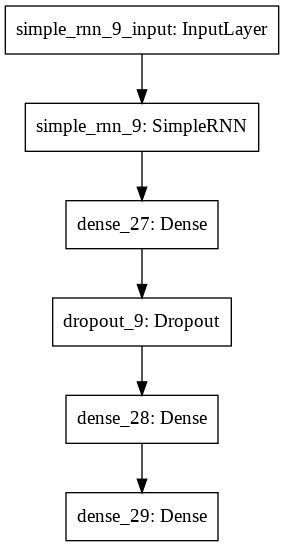

In [33]:
# Model Visualization
model = get_model()
plot_model(model)

In [34]:
model = get_model()
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, verbose=0, mode='min', min_delta=0.0001, min_lr=0.000000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.00001)

tensorboard = TensorBoard(log_dir="logs",write_graph=True)
filepath = './best_rnn_model.hdf5'
model_check_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

LR = 1e-3
EPOCH = 200
opt = Adam(lr=LR, decay=LR/EPOCH)
# opt = Adam(lr=LR)
# opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss='mae')

In [35]:
model_history = model.fit(
                            train_x, train_y, 
                            epochs=EPOCH, 
                            batch_size=32, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [reduce_lr_on_plateau, tensorboard, model_check_point,early_stopping]
                        )

Epoch 1/200
49/49 [==============================] - 6s 110ms/step - loss: 0.3143 - val_loss: 0.0921
Epoch 2/200
49/49 [==============================] - 4s 86ms/step - loss: 0.1016 - val_loss: 0.0674
Epoch 3/200
49/49 [==============================] - 4s 90ms/step - loss: 0.0740 - val_loss: 0.0794
Epoch 4/200
49/49 [==============================] - 4s 88ms/step - loss: 0.0730 - val_loss: 0.0691
Epoch 5/200
49/49 [==============================] - 4s 89ms/step - loss: 0.0659 - val_loss: 0.0729
Epoch 6/200
49/49 [==============================] - 4s 86ms/step - loss: 0.0645 - val_loss: 0.0536
Epoch 7/200
49/49 [==============================] - 4s 90ms/step - loss: 0.0657 - val_loss: 0.1029
Epoch 8/200
49/49 [==============================] - 4s 89ms/step - loss: 0.0551 - val_loss: 0.1278
Epoch 9/200
49/49 [==============================] - 4s 87ms/step - loss: 0.0587 - val_loss: 0.1352
Epoch 10/200
49/49 [==============================] - 4s 91ms/step - loss: 0.0586 - val_loss: 0.129

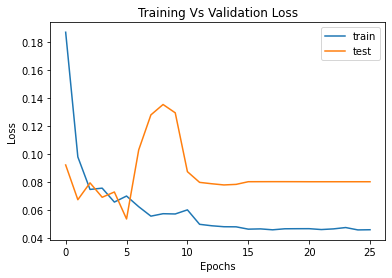

In [36]:
# Plot training loss vs validation loss
plt.title('Training Vs Validation Loss')
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# load best rnn model
rnn_best_model = keras.models.load_model(filepath)

In [ ]:
# report error. Benchmark for reference
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.04625543658630555
test MAE error for standard averaging: 0.04963793676829961


In [38]:
# report error
train_pred = rnn_best_model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = rnn_best_model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.052212000312542306
test MAE error for standard averaging: 0.04182275231718211


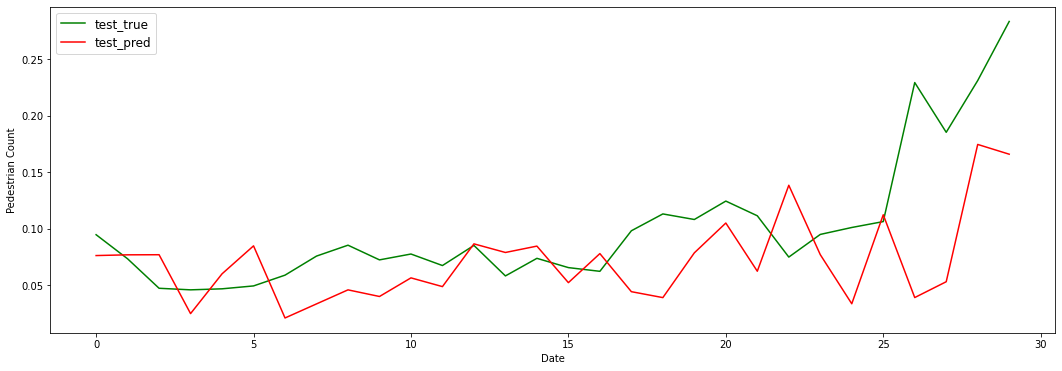

In [39]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Tabular comparison of predicted vs ground truth
test_scaled = df_norm.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
test_predicted_denorm = scaler.inverse_transform(test_scaled)[:,-1]
test_true_denorm = df.iloc[-LAST_N_DAYS:,-1]

rnn_test_comp = pd.DataFrame(data = {'predicted':test_predicted_denorm, 'ground_truth':test_true_denorm})
rnn_test_comp['diff'] = (rnn_test_comp['predicted']-rnn_test_comp['ground_truth']).abs()
print(rnn_test_comp)
print('-----------------_')
print('Mean diff in prediction and ground truth', np.mean(rnn_test_comp['diff']))

          predicted  ground_truth           diff
2102  114271.442933        164619   50347.557067
2103  146306.398547        141391    4915.398547
2104  131504.683184        112983   18521.683184
2105   75044.895854        111473   36428.104146
2106  198091.112496        112459   85632.112496
2107   93602.227498        115245   21642.772502
2108  130093.372381        125631    4462.372381
2109  128385.928418        144006   15620.071582
2110  117381.398174        154509   37127.601826
2111  175624.160742        140357   35267.160742
2112  169502.746592        146003   23499.746592
2113  135551.394775        134898     653.394775
2114  194135.029521        154291   39844.029521
2115  122733.688532        124895    2161.311468
2116  158090.995271        141843   16247.995271
2117  163009.216280        132910   30099.216280
2118  165308.590301        129324   35984.590301
2119  151123.489849        168411   17287.510151
2120  182743.713192        184648    1904.286808
2121  187266.976550 

In [44]:
# Tabular comparison of predicted vs ground truth
test_scaled = df_norm.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
test_predicted_denorm = scaler.inverse_transform(test_scaled)[:,-1]
test_true_denorm = df.iloc[-LAST_N_DAYS:,-1]

rnn_test_comp = pd.DataFrame(data = {'predicted':test_predicted_denorm, 'ground_truth':test_true_denorm})
rnn_test_comp['predicted'] = rnn_test_comp['predicted'].astype(int)
rnn_test_comp['diff'] = (rnn_test_comp['predicted']-rnn_test_comp['ground_truth']).abs()
print(rnn_test_comp)
print('-----------------_')
print('Mean diff in prediction and ground truth: ', int(np.mean(rnn_test_comp['diff'])))

      predicted  ground_truth    diff
2102     144519        164619   20100
2103     145226        141391    3835
2104     145319        112983   32336
2105      88565        111473   22908
2106     126905        112459   14446
2107     153862        115245   38617
2108      84351        125631   41280
2109      97917        144006   46089
2110     111454        154509   43055
2111     105061        140357   35296
2112     123010        146003   22993
2113     114585        134898   20313
2114     155800        154291    1509
2115     147486        124895   22591
2116     153629        141843   11786
2117     118410        132910   14500
2118     146408        129324   17084
2119     109702        168411   58709
2120     103988        184648   80660
2121     147137        179286   32149
2122     175877        197031   21154
2123     129423        182863   53440
2124     212287        143054   69233
2125     145397        164891   19494
2126      98050        171577   73527
2127     183

# LSTM

Add LSTM model here

In [45]:
def get_lstm_model():
  np.random.seed(37)
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Dense(128))
  model.add(Dense(1))
  return model

model = get_lstm_model()
opt = Adam(lr=1e-4)
model.compile(optimizer=opt, loss='mae')

model_history = model.fit(
                            train_x, train_y, 
                            epochs=100, 
                            batch_size=64, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [early_stopping, reduce_lr_on_plateau]
                        )

Epoch 1/100
25/25 [==============================] - 30s 29ms/step - loss: 0.3107 - val_loss: 0.0907
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 0.1054 - val_loss: 0.1115
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0817 - val_loss: 0.1206
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0783 - val_loss: 0.1165
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0793 - val_loss: 0.1197
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0784 - val_loss: 0.1152
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0763 - val_loss: 0.1153
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0745 - val_loss: 0.1154
Epoch 9/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0763 - val_loss: 0.1157
Epoch 10/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0776 - val_loss: 0.115

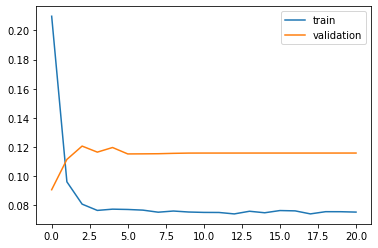

In [46]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# report error
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.06483747427761659
test MAE error for standard averaging: 0.02680290353680014


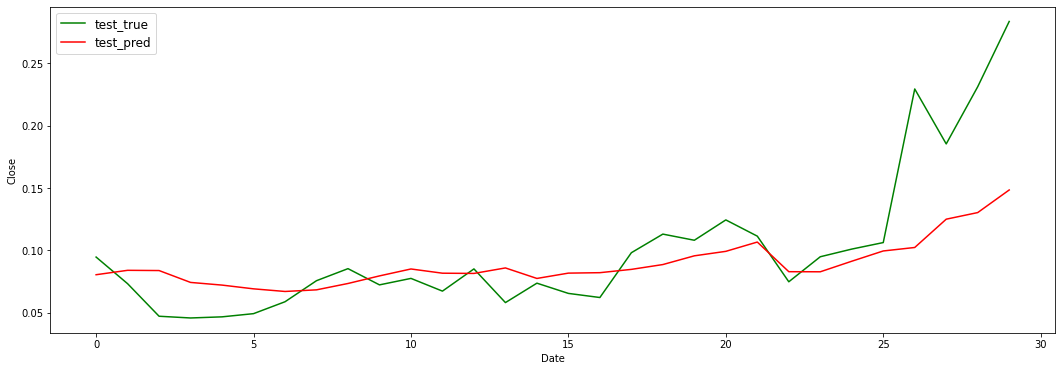

In [ ]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(fontsize=12)
plt.show()

In [48]:
# Tabular comparison of predicted vs ground truth
test_scaled = df_norm.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
test_predicted_denorm = scaler.inverse_transform(test_scaled)[:,-1]
test_true_denorm = df.iloc[-LAST_N_DAYS:,-1]

rnn_test_comp = pd.DataFrame(data = {'predicted':test_predicted_denorm, 'ground_truth':test_true_denorm})
rnn_test_comp['predicted'] = rnn_test_comp['predicted'].astype(int)
rnn_test_comp['diff'] = (rnn_test_comp['predicted']-rnn_test_comp['ground_truth']).abs()
print(rnn_test_comp)
print('-----------------_')
print('Mean diff in prediction and ground truth: ', int(np.mean(rnn_test_comp['diff'])))

      predicted  ground_truth    diff
2102     286645        164619  122026
2103     289719        141391  148328
2104     289571        112983  176588
2105     287263        111473  175790
2106     287655        112459  175196
2107     282762        115245  167517
2108     279729        125631  154098
2109     280605        144006  136599
2110     283401        154509  128892
2111     286275        140357  145918
2112     286654        146003  140651
2113     286639        134898  151741
2114     286494        154291  132203
2115     287665        124895  162770
2116     287540        141843  145697
2117     288217        132910  155307
2118     288387        129324  159063
2119     286498        168411  118087
2120     290563        184648  105915
2121     295106        179286  115820
2122     298931        197031  101900
2123     304531        182863  121668
2124     293982        143054  150928
2125     303461        164891  138570
2126     303347        171577  131770
2127     302